# ノビバンドデータ試し
- yの値をmeanが3以上の時ではなく個人個人で定義する必要がありそう
- 標準偏差１個分とか？にする？→こうしてみた


In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [2]:
date = '20220620'
n_experiment = 1

In [41]:
def create_X_y():
    INPUT_DIR = '../data/'
    _X = pd.read_csv(INPUT_DIR + f'{date}_X.csv')
    _y = pd.read_csv(INPUT_DIR + f'{date}_y.csv')
    df = _X.merge(_y[['タイムスタンプ', 'y']], how='left', left_on='日付', right_on='タイムスタンプ').fillna(0)
    X = df[df.columns[2:13]]
    y = df['y']
    return X, y

In [42]:
def MTS(X, y):
    print('MTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    result_scaler, result_inv_C, select_columns = fit_MTS(X_train, y_train)

    y_train_pred = predict_MD(X_train, result_scaler, result_inv_C, select_columns)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba = predict_MD(X_test, result_scaler, result_inv_C, select_columns)
    y_pred = y_proba > threshold

    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    sns.lineplot(x=X.index, y=predict_MD(X, result_scaler, result_inv_C, select_columns))
    plt.scatter(x=y[y == 1].index, y=predict_MD(X, result_scaler, result_inv_C, select_columns)[y == 1], c='r')
    plt.show()

In [43]:
def WMTS(X, y):
    print('WMTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight = fit_WMTGS(X_train, y_train)
    y_train_pred = cal_gram_WMD_by_reduced_model(X_train, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba, y_pred = predict_WMTGS(X_test, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)


    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_WMTGS(X, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [44]:
def ImpAggMTSBag(X, y):
    print('ImpAggMTSBag')
    n_estimators = 10
    max_samples = 0.8
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    # n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
    SIZE = int(len(X) * max_samples)
    # 予測に必要なパラメータ
    select_columns = [0] * n_estimators
    result_scaler = [0] * n_estimators
    result_inv_C = [0] * n_estimators
    threshold = [0] * n_estimators

    for i in range(n_estimators):
        # bootstrap sampling
        resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
        random_s = random.sample(
            list(resampled_data_x.columns), 
            len(resampled_data_x.columns) 
            if len(resampled_data_x.columns) < 7 
            else 7
            )
        resampled_data_x = resampled_data_x[random_s]

        result_scaler[i], result_inv_C[i], select_columns[i] = fit_MTS(resampled_data_x, resampled_data_y)

        y_train_pred = predict_MD(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i])

        threshold[i] = determine_threshold(resampled_data_y, y_train_pred)
        
    y_proba, y_pred = predict_MTSBag_ImpAgg(X_test, result_scaler, result_inv_C, select_columns, threshold, n_estimators)
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_MTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [45]:
def ImpAggWMTSBag(X, y):
    print('ImpAggWMTSBag')
    n_estimators = 10
    max_samples = 0.8
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    # n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
    SIZE = int(len(X) * max_samples)

    # 予測に必要なパラメータ
    select_columns = [0] * n_estimators
    select_columns_weight = [0] * n_estimators
    result_scaler = [0] * n_estimators
    result_inv_C = [0] * n_estimators
    threshold = [0] * n_estimators

    for i in range(n_estimators):
        # bootstrap sampling
        resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
        random_s = random.sample(
            list(resampled_data_x.columns), 
            len(resampled_data_x.columns) 
            if len(resampled_data_x.columns) < 7 
            else 7
            )
        resampled_data_x = resampled_data_x[random_s]

        result_scaler[i], result_inv_C[i], select_columns[i], select_columns_weight[i] = fit_WMTS(resampled_data_x, resampled_data_y)

        y_train_pred = cal_WMD_by_reduced_model(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i], select_columns_weight[i])

        threshold[i] = determine_threshold(resampled_data_y, y_train_pred)

    y_proba, y_pred = predict_WMTSBag_ImpAgg(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold, n_estimators)

    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_WMTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold, n_estimators)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [46]:
def logistic(X, y):
    print('logistic')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [47]:
def LGBM(X, y):
    print('LGBM')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    
    import lightgbm

    lr = lightgbm.LGBMClassifier(min_child_samples=5) # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [48]:
def exp(X, y):
    MTS(X,y)
    WMTS(X,y)
    ImpAggMTSBag(X, y)
    ImpAggWMTSBag(X,y)
    logistic(X,y)
    LGBM(X,y)

MTS


AUC            0.638889
accuracy       0.633333
recall         0.666667
Specificity         0.5
precision      0.842105
gmeans          0.57735
RS             1.333333
Name: 0, dtype: object

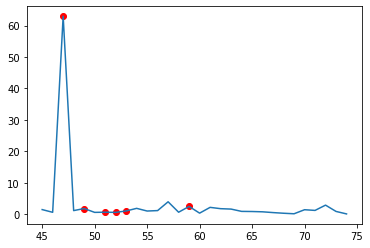

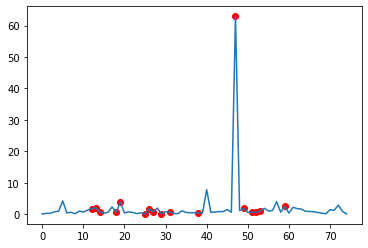

WMTS


AUC            0.534722
accuracy            0.6
recall            0.625
Specificity         0.5
precision      0.833333
gmeans         0.559017
RS                 1.25
Name: 0, dtype: object

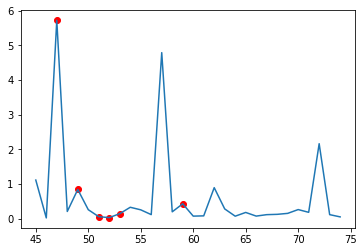

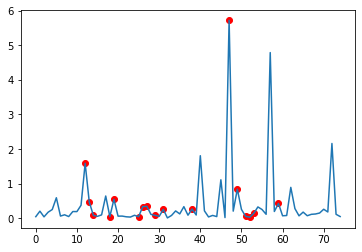

ImpAggMTSBag


AUC            0.347222
accuracy       0.666667
recall         0.791667
Specificity    0.166667
precision      0.791667
gmeans         0.363242
RS                 4.75
Name: 0, dtype: object

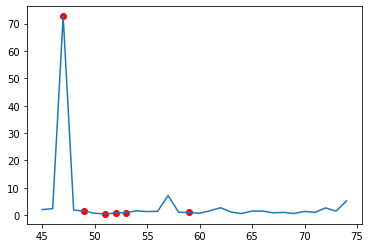

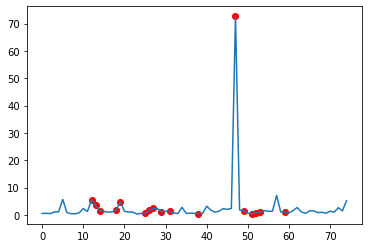

ImpAggWMTSBag


AUC              0.4375
accuracy       0.566667
recall         0.583333
Specificity         0.5
precision      0.823529
gmeans         0.540062
RS             1.166667
Name: 0, dtype: object

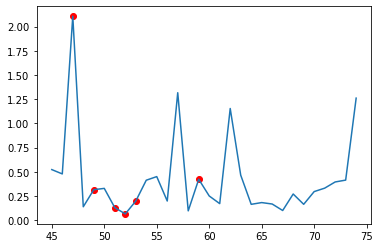

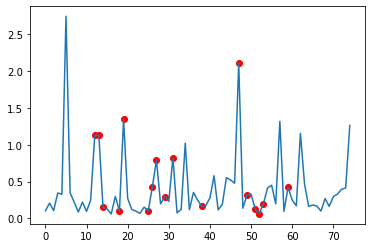

logistic


c:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC            0.458333
accuracy            0.6
recall         0.708333
Specificity    0.166667
precision      0.772727
gmeans         0.343592
RS                 4.25
Name: 0, dtype: object

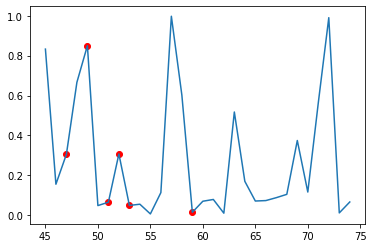

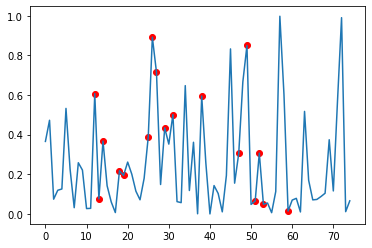

LGBM


AUC            0.597222
accuracy       0.733333
recall            0.875
Specificity    0.166667
precision      0.807692
gmeans         0.381881
RS                 5.25
Name: 0, dtype: object

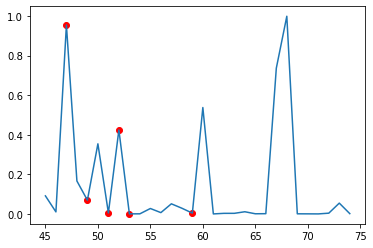

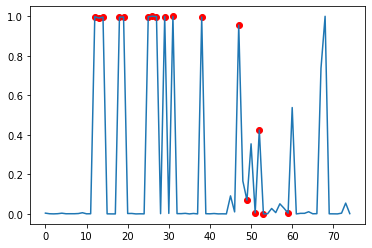

In [57]:
exp(*create_X_y())